In [1]:
import os

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


# Experimental file to compare results on GHGEmissions using standard scaled data, and using data transformed with the Box Cox method

- Same index will be used for splits

In [2]:
file_bcx = "./data/data_bcx.csv"
file_std = "./data/seattle_predict_ghg_eui.csv"

df_bcx = pd.read_csv(file_bcx)
df_bcx.set_index("OSEBuildingID", inplace=True)
df_std = pd.read_csv(file_std)
df_std.set_index("OSEBuildingID", inplace=True)


In [3]:
target = "target_GHGEmissionsIntensity(kgCO2e/ft2)"

In [4]:
# Target : target_GHGEmissionsIntensity(kgCO2e/ft2) :

droplist_bcx = [
    "bcx_GHGEmissionsIntensity(kgCO2e/ft2)", # Transformed target
    "target_SourceEUI(kWh/m2)", # not to scale
    ]

df_bcx.drop(columns=droplist_bcx, inplace=True)


In [5]:
# Target : target_GHGEmissionsIntensity(kgCO2e/ft2) :

droplist_std = [
    "scaled_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "target_SourceEUI(kWh/m2)",  # not to scale
    ]

df_std.drop(columns=droplist_std, inplace=True)


In [6]:
std_reg = Linear_reg(dataframe=df_std, target=target)


In [7]:
# Let's see if the split if any good : 

alphas_ridge = np.arange(0.1, 45, 0.5)
alphas_elnet = np.arange(0.1, 45, 0.5)
alphas_lasso = np.arange(0.01, 15, 0.04)

std_reg.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)


Ridge: 

Ridge best Alpha : 8.6
Time used during fit = 0.020413166843354702
Time used during predict = 7.541710510849953e-05


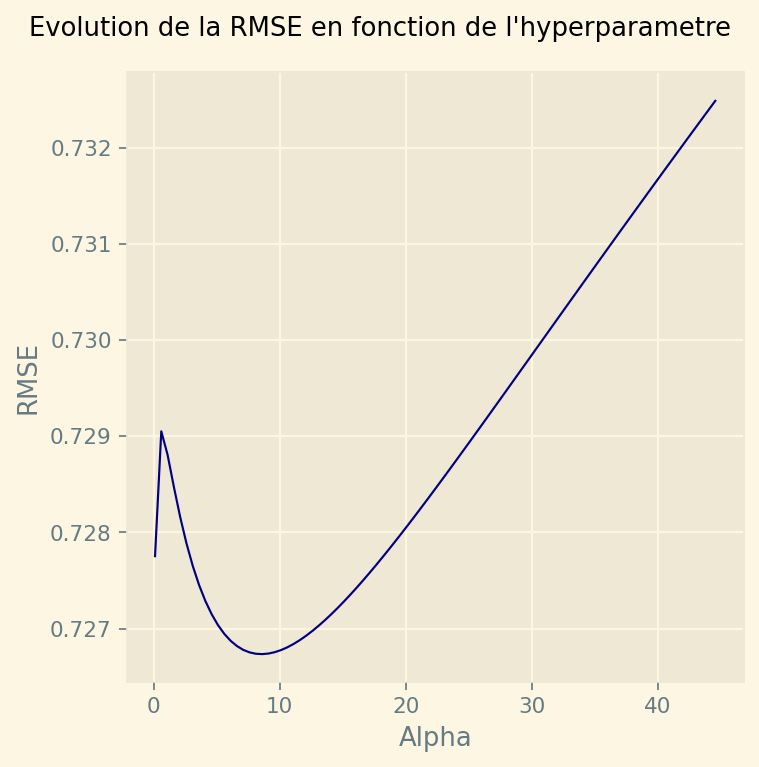

In [8]:
print("Ridge: \n")
print(f"Ridge best Alpha : {std_reg.ridge_cv.alpha_}")
print(f"Time used during fit = {std_reg.ridge_time_card.t_fit}")
print(f"Time used during predict = {std_reg.ridge_time_card.t_predict}")

std_reg.ridge_plot()


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.22051683394238353
Time used during predict = 0.0044617499224841595


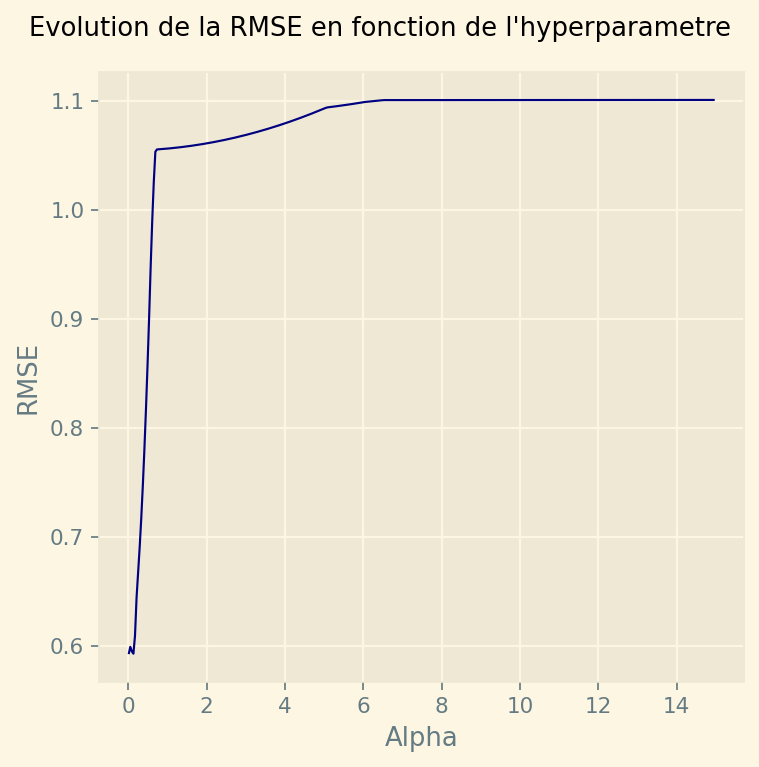

In [9]:
print("LASSO: \n")
print(f"LASSO best Alpha : {std_reg.lasso_cv.alpha_}")
print(f"Time used during fit = {std_reg.lasso_time_card.t_fit}")
print(f"Time used during predict = {std_reg.lasso_time_card.t_predict}")

std_reg.lasso_plot()


In [10]:
# Common indexes : 

ids_train, ids_test = freeze_model(model=std_reg)


In [11]:
bcx_reg = Linear_reg(dataframe=df_bcx, target=target)

# Splitting to same indexes
bcx_train = df_bcx[df_bcx.index.isin(ids_train)]
bcx_test = df_bcx[df_bcx.index.isin(ids_test)]

# Checking : 

for idx in bcx_train.index:
    if idx not in std_reg.df_train.index:
        print("oops")
    
print("train checked")

for idx in bcx_test.index:
    if idx not in std_reg.df_test.index:
        print("oops")

print("test checked")
    

train checked
test checked


In [12]:
bcx_reg.force_split(df_train_ovr=bcx_train, df_test_ovr=bcx_test)


In [13]:
bcx_reg.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
    )


Ridge: 

Ridge best Alpha : 9.6
Time used during fit = 0.05236633401364088
Time used during predict = 8.091609925031662e-05


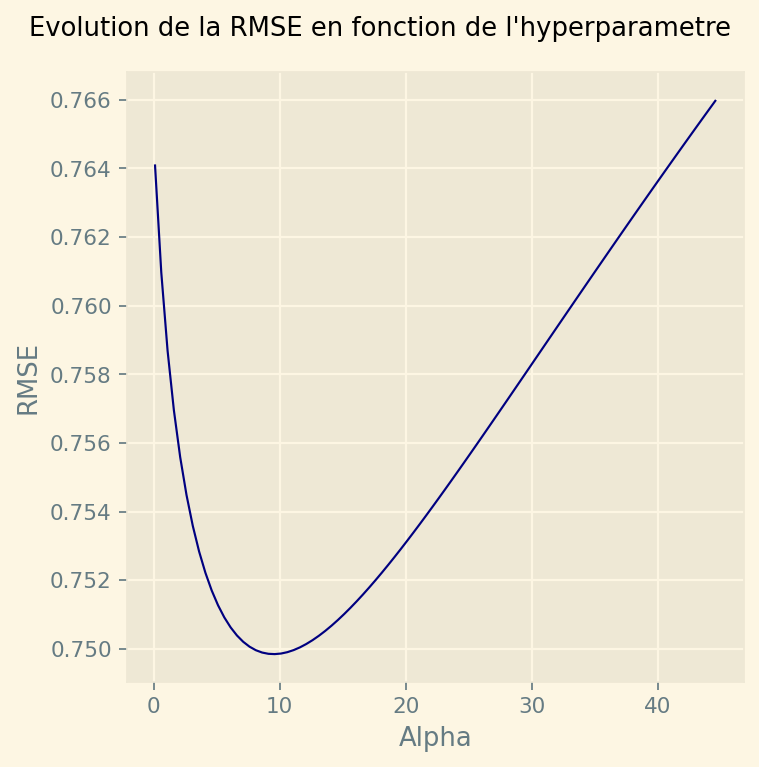

In [14]:
print("Ridge: \n")
print(f"Ridge best Alpha : {bcx_reg.ridge_cv.alpha_}")
print(f"Time used during fit = {bcx_reg.ridge_time_card.t_fit}")
print(f"Time used during predict = {bcx_reg.ridge_time_card.t_predict}")

bcx_reg.ridge_plot()


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.193833792116493
Time used during predict = 0.004189667291939259


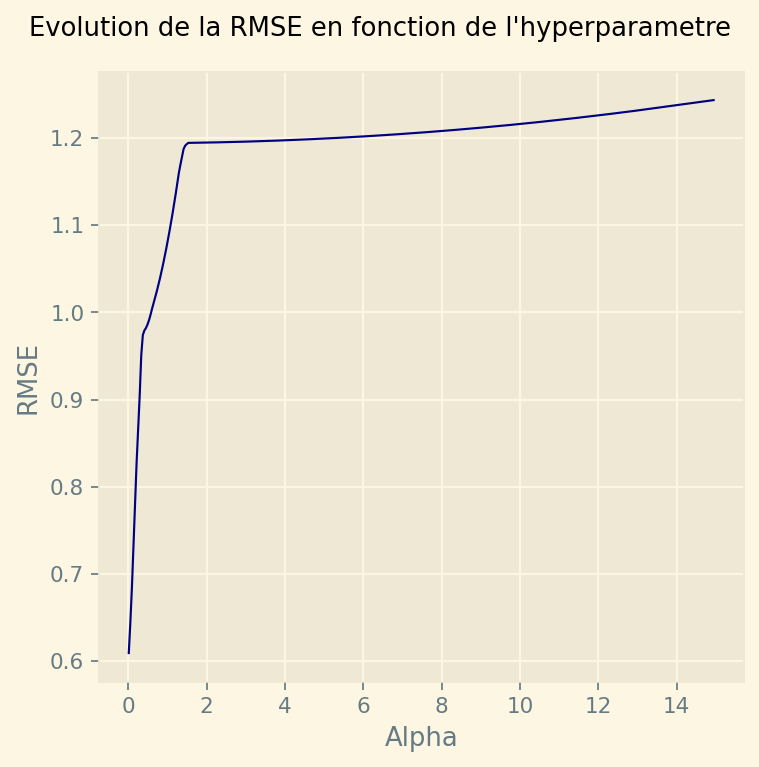

In [15]:
print("LASSO: \n")
print(f"LASSO best Alpha : {bcx_reg.lasso_cv.alpha_}")
print(f"Time used during fit = {bcx_reg.lasso_time_card.t_fit}")
print(f"Time used during predict = {bcx_reg.lasso_time_card.t_predict}")

bcx_reg.lasso_plot()


In [16]:
# Similar behaviour at different values, lets check metrics :

std_reg.format_all_metrics()


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.753758,0.452196,0.726736,0.647410,0.769693,0.623412,0.998174,0.607209
Test,0.673435,0.512976,0.655216,0.538971,0.659482,0.532949,0.655247,0.538928


In [17]:
bcx_reg.format_all_metrics()

,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.776459,0.422650,0.749847,0.598962,0.779861,0.575167,1.026182,0.553004
Test,0.718655,0.445374,0.710922,0.457246,0.713701,0.452994,0.718778,0.445184


In [18]:
# OK so bcx is worse overall, nice, lets check with cv=Rkfolds

k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
bcx_reg.common_parameters["cv"] = k_folds
std_reg.common_parameters["cv"] = k_folds


In [19]:
bcx_reg.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
    )

std_reg.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)

In [20]:
bcx_reg.format_all_metrics()


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.771432,0.441350,0.684024,0.600260,0.772514,0.575167,1.019093,0.553004
Test,0.718655,0.445374,0.711046,0.457057,0.713701,0.452994,0.718778,0.445184


In [21]:
std_reg.format_all_metrics()


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.733875,0.471731,0.695812,0.633747,0.755993,0.555441,0.996784,0.607209
Test,0.673435,0.512976,0.653539,0.541327,0.675498,0.509988,0.655247,0.538928


In [22]:
# Still worse, ok nice, lets forget about Box Cox
